## Overview

The goal of this notebook is to gather data from the National Transit Database (NTD) and parse it into something usable for our transit carbon calculations. There are two datasets we need to import and parse, one being [NTD Annual Data - Fuel and Energy](https://data.transportation.gov/Public-Transit/2022-NTD-Annual-Data-Fuel-and-Energy/8ehq-7his/data) set, and the other being [NTD Service](https://www.transit.dot.gov/ntd/data-product/2022-service).

#### To Maintain

To update the data each year, update `urls` below with the most recent download links.

In [1]:
ntd_urls = {
  2022: {
    # https://www.transit.dot.gov/ntd/data-product/2022-fuel-and-energy
    "fuel_energy_csv": "https://data.transportation.gov/api/views/8ehq-7his/rows.csv?date=20231027&accessType=DOWNLOAD&bom=true&format=true",
    # https://www.transit.dot.gov/ntd/data-product/2022-service
    "service_csv": "https://data.transportation.gov/api/views/4fir-qbim/rows.csv?date=20231102&accessType=DOWNLOAD&bom=true&format=true",
    # https://www.transit.dot.gov/ntd/data-product/2022-annual-database-agency-information
    "agency_info_xlsx": "https://www.transit.dot.gov/sites/fta.dot.gov/files/2024-07/2022%20Agency%20Information_1-3_0.xlsx",
  },
  2021: {
    # https://www.transit.dot.gov/ntd/data-product/2021-fuel-and-energy
    "fuel_energy_xlsx": "https://www.transit.dot.gov/sites/fta.dot.gov/files/2023-12/2021%20Fuel%20and%20Energy_1-1_0.xlsx",
    # https://www.transit.dot.gov/ntd/data-product/2021-service
    "service_xlsx": "https://www.transit.dot.gov/sites/fta.dot.gov/files/2022-10/2021%20Service_static.xlsx",
    # https://www.transit.dot.gov/ntd/data-product/2021-annual-database-agency-information
    "agency_info_xlsx": "https://www.transit.dot.gov/sites/fta.dot.gov/files/2022-10/2021%20Agency%20Information.xlsx",
  },
  2020: {
    # https://www.transit.dot.gov/ntd/data-product/2020-fuel-and-energy
    "fuel_energy_xlsx": "https://www.transit.dot.gov/sites/fta.dot.gov/files/2023-12/2020-Fuel%20and%20Energy_1-1_1.xlsx",
    # https://www.transit.dot.gov/ntd/data-product/2020-service
    "service_zip": "https://www.transit.dot.gov/sites/fta.dot.gov/files/2020-Service.zip",
    # https://www.transit.dot.gov/ntd/data-product/2020-annual-database-agency-information
    "agency_info_xlsx": "https://www.transit.dot.gov/sites/fta.dot.gov/files/2021-11/2020%20Agency%20Information.xlsx",
  },
  2019: {
    # https://www.transit.dot.gov/ntd/data-product/2019-fuel-and-energy
    "fuel_energy_zip": "https://www.transit.dot.gov/sites/fta.dot.gov/files/Fuel%20and%20Energy.zip",
    # https://www.transit.dot.gov/ntd/data-product/2019-service
    "service_zip": "https://www.transit.dot.gov/sites/fta.dot.gov/files/Service.zip",
    # https://www.transit.dot.gov/ntd/data-product/2019-annual-database-agency-information
    "agency_info_xlsx": "https://www.transit.dot.gov/sites/fta.dot.gov/files/2021-05/2019%20Agency%20Info.xlsx",
  },
  2018: {
    # https://www.transit.dot.gov/ntd/data-product/2018-fuel-and-energy
    "fuel_energy_xlsm": "https://www.transit.dot.gov/sites/fta.dot.gov/files/Fuel%20and%20Energy_3.xlsm",
    # https://www.transit.dot.gov/ntd/data-product/2018-service
    "service_xlsm": "https://www.transit.dot.gov/sites/fta.dot.gov/files/Service_4.xlsm",
    # https://www.transit.dot.gov/ntd/data-product/2018-annual-database-agency-information
    "agency_info_xlsx": "https://www.transit.dot.gov/sites/fta.dot.gov/files/2018%20Agency%20Info_1.xlsx",
  }
}

# XLSX detailing urbanized areas; establishes relationship UACE Codes and UZA codes (which were used by NTD pre-2022)
census_changes_xlsx = "https://www.transit.dot.gov/sites/fta.dot.gov/files/2023-10/UZA_CHANGES_1990-2020_2_5.xlsx"

# CSV with relationship between ZCTA codes and UACE codes (from us_geo on GitHub)
zcta_urban_areas_urls = {
  2020: "https://raw.githubusercontent.com/bdurand/us_geo/master/data/dist/zcta_urban_areas.csv",
  2010: "https://raw.githubusercontent.com/bdurand/us_geo/master/data/2020_dist/zcta_urban_areas.csv"
}
# CSV with relationship between ZCTA codes and UZA codes (from acs-aggregate on GitHub)
zip_to_zcta_url = "https://raw.githubusercontent.com/censusreporter/acs-aggregate/master/crosswalks/zip_to_zcta/zip_zcta_xref.csv"

In [2]:
# imports

import pandas as pd
import matplotlib.pyplot as plt
import json

from script_utils import is_up_to_date, load_dataframe

# move to the 'src' directory so we can import from the 'emcommon' package
%cd ../src
import emcommon.metrics.footprint.util as emcmfu

/Users/jgreenle/openpath/e-mission-common/src


/Users/jgreenle/Library/Python/3.12/lib/python/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
# create UZA to UACE mapping using the NTD's census_changes_xlsx

census_changes_df = pd.read_excel(census_changes_xlsx)
census_changes_df = census_changes_df[["2010 NTD UZA Code (Deprecated)", "2020 UACE"]].dropna().astype(int)
# pad to 5 digits
census_changes_df['2020 UACE'] = census_changes_df['2020 UACE'].apply(lambda x: str(x).zfill(5))
uza_to_uace = census_changes_df.set_index("2010 NTD UZA Code (Deprecated)")["2020 UACE"].to_dict()
print("uza_to_uace: " + json.dumps(uza_to_uace))

uza_to_uace: {"1": "63217", "2": "51445", "3": "16264", "4": "56602", "7": "40429", "6": "22042", "5": "69076", "8": "92242", "9": "03817", "10": "09271", "12": "69184", "11": "23824", "14": "80389", "13": "78904", "15": "78661", "16": "57628", "17": "86599", "18": "23527", "22": "75340", "19": "04843", "23": "47995", "20": "77770", "24": "71317", "26": "78580", "28": "77068", "32": "65863", "21": "79093", "29": "79039", "37": "04384", "27": "69697", "25": "17668", "33": "41212", "30": "16885", "31": "43912", "36": "19234", "34": "90892", "38": "15670", "35": "57466", "39": "72505", "40": "42346", "42": "78499", "44": "61273", "50": "73261", "45": "74746", "41": "56116", "51": "65080", "47": "37243", "43": "51755", "49": "62677", "46": "11350", "48": "10162", "52": "88732", "53": "27253", "54": "39889", "58": "65269", "57": "52390", "64": "09536", "55": "07786", "56": "01171", "62": "88948", "63": "31843", "60": "75664", "76": "15508", "59": "22528", "69": "57709", "73": "18856", "68":

In [4]:
ntd_fuel_types = {
    "Gasoline": {"given_unit": "gal", "kwh_per_unit": emcmfu.KWH_PER_GAL_GASOLINE, "alias": "Gasoline"},
    "Diesel": {"given_unit": "gal", "kwh_per_unit": emcmfu.KWH_PER_GAL_DIESEL, "alias": "Diesel"},
    "Bio-Diesel": {"given_unit": "gal", "kwh_per_unit": emcmfu.KWH_PER_GAL_BIODIESEL, "alias": "Diesel"},
    "Liquefied Petroleum Gas": {"given_unit": "gal equivalent", "kwh_per_unit": emcmfu.KWH_PER_GAL_LPG, "alias": "LPG"},
    "Compressed Natural Gas": {"given_unit": "gal equivalent", "kwh_per_unit": emcmfu.KWH_PER_GAL_CNG, "alias": "CNG"},
    "Hydrogen": {"given_unit": "kg", "kwh_per_unit": emcmfu.KWH_PER_KG_HYDROGEN, "alias": "Hydrogen"},
    "Electric Propulsion": {"given_unit": "kWh", "kwh_per_unit": 1, "alias": "Electric"},
    "Electric Battery": {"given_unit": "kWh", "kwh_per_unit": 1, "alias": "Electric"},
    "Other Fuel": {"given_unit": "gal/gal equivalent", "kwh_per_unit": emcmfu.KWH_PER_GAL_OTHER, "alias": "Other"}
}
fuel_types = ['Gasoline', 'Diesel', 'LPG', 'CNG', 'Hydrogen', 'Electric', 'Other']
fuel_types_all = fuel_types + ['All Fuels']

def agg_by_ntd_id_and_mode(df):
    # remove commas, convert to numeric, and sort
    df = df.replace({',': ''}, regex=True)
    df = df.apply(pd.to_numeric, errors='ignore')
    df = df.sort_values(by=['NTD ID', 'Mode'])
    # sum rows with the same NTD ID and Mode
    df = df.groupby(['NTD ID', 'Mode'], as_index=False).sum()
    return df

In [5]:
def make_fuel_energy_df(y):
    df = load_dataframe(ntd_urls[y], 'fuel_energy', 'Fuel and Energy')
    col_renames = {
        # kwh -> kWh
        'Electric Propulsion (kwh)': 'Electric Propulsion (kWh)',
        'Electric Battery (kwh)': 'Electric Battery (kWh)',
        # require renames as older years did not include (miles) in the column name
        'Diesel': 'Diesel (miles)',
        'Gasoline': 'Gasoline (miles)',
        'Liquefied Petroleum Gas': 'Liquefied Petroleum Gas (miles)',
        'Compressed Natural Gas': 'Compressed Natural Gas (miles)',
        # 'Bio-Diesel': 'Bio-Diesel (miles)',
        'Hydrogen': 'Hydrogen (miles)',
        'Other Fuel': 'Other Fuel (miles)',
        'Electric Propulsion': 'Electric Propulsion (miles)',
        'Electric Battery': 'Electric Battery (miles)',
    }
    df = df.rename(columns=col_renames)

    if 'UACE Code' not in df.columns:
        agency_info_df = load_dataframe(ntd_urls[y], 'agency_info')[['NTD ID', 'Primary UZA']]
        agency_info_df['UACE Code'] = agency_info_df['Primary UZA'].map(uza_to_uace)
        ntd_id_uace_map = agency_info_df.set_index('NTD ID')['UACE Code'].to_dict()
    else:
        ntd_id_uace_map = df.set_index('NTD ID')['UACE Code'].to_dict()

    df = agg_by_ntd_id_and_mode(df)

    df['UACE Code'] = df['NTD ID'].map(ntd_id_uace_map)
    print(f"dropping {len(df[df['UACE Code'].isna()])} rows with missing UACE Code")
    df = df.dropna(subset=['UACE Code'])
    df['UACE Code'] = df['UACE Code'].apply(lambda x: str(x).zfill(5))

    # for all fuel types, convert to km
    for fuel in ntd_fuel_types:
        old_col_name = fuel + ' (miles)'
        new_col_name = ntd_fuel_types[fuel]['alias'] + ' (km)'
        if new_col_name in df.columns and old_col_name in df.columns:
            df[new_col_name] += df[old_col_name] / emcmfu.MI_PER_KM
        elif old_col_name in df.columns:
            df[new_col_name] = df[old_col_name] / emcmfu.MI_PER_KM
        elif new_col_name not in df.columns:
            df[new_col_name] = 0

    # for all fuel types, convert to kWh
    def get_old_col_name(fuel_type): return fuel_type + ' (' + ntd_fuel_types[fuel_type]['given_unit'] + ')'
    for fuel in ntd_fuel_types:
        old_col_name = get_old_col_name(fuel)
        new_col_name = ntd_fuel_types[fuel]['alias'] + ' (kWh)'

        if new_col_name in df.columns and old_col_name in df.columns:
            df[new_col_name] += df[old_col_name] * ntd_fuel_types[fuel]['kwh_per_unit']
        elif old_col_name in df.columns:
            df[new_col_name] = df[old_col_name] * ntd_fuel_types[fuel]['kwh_per_unit']
        elif new_col_name not in df.columns:
            df[new_col_name] = 0

    # any rows where km is present but kWh is not, or vice versa, fill with 0
    for fuel in fuel_types:
        df[df[fuel + ' (km)'].notna()].where(df[fuel + ' (kWh)'].isna(), 0, inplace=True)
        df[df[fuel + ' (kWh)'].notna()].where(df[fuel + ' (km)'].isna(), 0, inplace=True)

    df['All Fuels (kWh)'] = sum([df[f + ' (kWh)'].fillna(0) for f in fuel_types])
    df['All Fuels (km)'] = sum([df[f + ' (km)'].fillna(0) for f in fuel_types])
    df = df[df['All Fuels (km)'] != 0]
    for fuel in fuel_types_all:
        df[f"{fuel} (%)"] = df[f"{fuel} (km)"] / df['All Fuels (km)'] * 100

    # now add a wh/km column for each fuel type
    for fuel in fuel_types_all:
        if f"{fuel} (km)" not in df.columns: continue
        df[f"{fuel} (Wh/km)"] = (df[f"{fuel} (kWh)"] * 1000 / df[f"{fuel} (km)"])
        # fill missing values with 0
        df[f"{fuel} (Wh/km)"] = df[f"{fuel} (Wh/km)"].fillna(0)
        # replace infinite values with 0
        df[f"{fuel} (Wh/km)"] = df[f"{fuel} (Wh/km)"].replace([float('inf'), float('-inf')], 0)

    return df

In [6]:
def make_service_df(y):
    df = load_dataframe(ntd_urls[y], 'service', 'Annual Service Data By Mode')
    col_renames = {
        'Passenger Miles Traveled': 'Passenger Miles',
        'Unlinked Passenger Trips (UPT)': 'Unlinked Passenger Trips',
        'Actual Vehicle/Passenger Car Miles': 'Vehicle Miles',
    }
    df = df.rename(columns=col_renames)
    df = agg_by_ntd_id_and_mode(df)

    # convert miles columns to km
    miles_cols = ['Vehicle Miles', 'Train Miles', 'Passenger Miles']
    for col in miles_cols:
        new_col_name = col.replace('Miles', 'km')
        df[new_col_name] = df[col] / emcmfu.MI_PER_KM
    df = df.drop(columns=miles_cols)

    # remove rows that have "Passenger km" = 0 or "Vehicle km" = 0
    df = df[(df['Passenger km'] != 0) & (df['Vehicle km'] != 0)]

    # For "Average Passengers", we want the passenger load on the engine
    # For rail modes, this is 'Train km'
    # For non-rail modes, this is 'Vehicle km' ('Train km' will be 0)
    # The average number of passengers is 'Passenger km' / ('Train km' || 'Vehicle km')
    engine_km = df['Train km'].replace(0, pd.NA).fillna(df['Vehicle km'])
    df['Average Passengers'] = df['Passenger km'] / engine_km

    return df

In [7]:
# merge the dataframes

def make_merged_ntd_df(y):
    fuel_energy_df = make_fuel_energy_df(y)
    service_df = make_service_df(y)
    df = fuel_energy_df.merge(service_df, on=['NTD ID', 'Mode'], suffixes=('', '_service'))

    # convert (Wh/km) columns to (Wh/pkm) columns
    for f in fuel_types_all:
        df[f"{f} (Wh/pkm)"] = df[f"{f} (Wh/km)"] / df['Average Passengers']

    # only keep relevant columns
    df = df[['NTD ID', 'Mode', 'UACE Code']
            + [f + ' (%)' for f in fuel_types_all]
            + [f + ' (Wh/pkm)' for f in fuel_types_all]
            + ['Unlinked Passenger Trips']]

    return df


In [8]:
def plot_whpkm_hists(df, title):
    modes = df['Mode'].unique()
    _, axs = plt.subplots(1, 2, figsize=(15, 5))
    for mode in modes:
        values = []
        for fuel_type in fuel_types_all:
            values.extend(df[df['Mode'] == mode][fuel_type + ' (Wh/pkm)'].dropna())
        axs[0].hist(values, bins=50, alpha=0.5, label=mode, log=True)
        print(f"{mode} desc: {pd.Series(values).astype(float).describe()}")

    axs[0].set_xlabel('Wh/pkm')
    axs[0].set_ylabel('Frequency')
    axs[0].set_title(title + ', by mode')
    axs[0].legend()

    for fuel_type in fuel_types_all:
        axs[1].hist(df[fuel_type + ' (Wh/pkm)'].dropna(), bins=50, alpha=0.5, label=fuel_type, log=True)
        print(f"{fuel_type} desc: {df[fuel_type + ' (Wh/pkm)'].dropna().astype(float).describe()}")
    axs[1].set_xlabel('Wh/pkm')
    axs[1].set_ylabel('Frequency')
    axs[1].set_title(title + ', by fuel type')
    axs[1].legend()
    plt.show()

def remove_outliers(df):
    print("Removing outliers")
    modes = df['Mode'].unique()
    bounds = {}
    for mode in modes:
        q1 = df[df['Mode'] == mode]['All Fuels (Wh/pkm)'].quantile(0.25)
        q3 = df[df['Mode'] == mode]['All Fuels (Wh/pkm)'].quantile(0.75)
        iqr = q3 - q1
        bounds[mode] = (q1 - 1.5 * iqr, q3 + 1.5 * iqr)

    df = df.replace(0, pd.NA)
    for fuel_type in fuel_types_all:
        # find rows where Wh/pkm is less than bounds[df['Mode']] or greater than bounds[df['Mode']]
        outliers = df[(df[fuel_type + ' (Wh/pkm)'] < df['Mode'].apply(lambda x: bounds[x][0])) | \
                      (df[fuel_type + ' (Wh/pkm)'] > df['Mode'].apply(lambda x: bounds[x][1]))].index
        for outlier in outliers:
            o = df.loc[outlier]
            print(f"Removing {o['Mode']} outlier: expected {bounds[o['Mode']]}, got {o.to_dict()}")
            df.at[outlier, fuel_type + ' (Wh/pkm)'] = pd.NA
            df.at[outlier, fuel_type + ' (%)'] = pd.NA
    plot_whpkm_hists(df, 'Distribution of Wh/pkm after removing outliers')

    return df

Make the dfs for each year and ouput `.json` files in `emcommon/metrics/footprint/ntd_data/`

Creating ../src/emcommon/resources/ntd2022_intensities.json


/var/folders/v0/c_n37phn7sq88dx8kvylb8_1c1j_mc/T/ipykernel_1064/857962386.py:18: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


dropping 0 rows with missing UACE Code


/var/folders/v0/c_n37phn7sq88dx8kvylb8_1c1j_mc/T/ipykernel_1064/857962386.py:18: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/var/folders/v0/c_n37phn7sq88dx8kvylb8_1c1j_mc/T/ipykernel_1064/9921474.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  engine_km = df['Train km'].replace(0, pd.NA).fillna(df['Vehicle km'])


Removing outliers
Removing MB outlier: expected (np.float64(-836.9366924731983), np.float64(3652.4162827185623)), got {'NTD ID': 5, 'Mode': 'MB', 'UACE Code': '80389', 'Gasoline (%)': 0.004049225883287018, 'Diesel (%)': 85.55657006748709, 'LPG (%)': None, 'CNG (%)': None, 'Hydrogen (%)': None, 'Electric (%)': 14.439380706629615, 'Other (%)': None, 'All Fuels (%)': 100.0, 'Gasoline (Wh/pkm)': 14441.991612092006, 'Diesel (Wh/pkm)': 1662.8918812709612, 'LPG (Wh/pkm)': None, 'CNG (Wh/pkm)': None, 'Hydrogen (Wh/pkm)': None, 'Electric (Wh/pkm)': 792.8007138479063, 'Other (Wh/pkm)': None, 'All Fuels (Wh/pkm)': 1537.7735597259395, 'Unlinked Passenger Trips': 1007952}
Removing DR outlier: expected (np.float64(-665.5973216040134), np.float64(6444.472067937465)), got {'NTD ID': 24, 'Mode': 'DR', 'UACE Code': '71317', 'Gasoline (%)': 1.1321521013038813, 'Diesel (%)': 98.86784789869611, 'LPG (%)': None, 'CNG (%)': None, 'Hydrogen (%)': None, 'Electric (%)': None, 'Other (%)': None, 'All Fuels (%)':

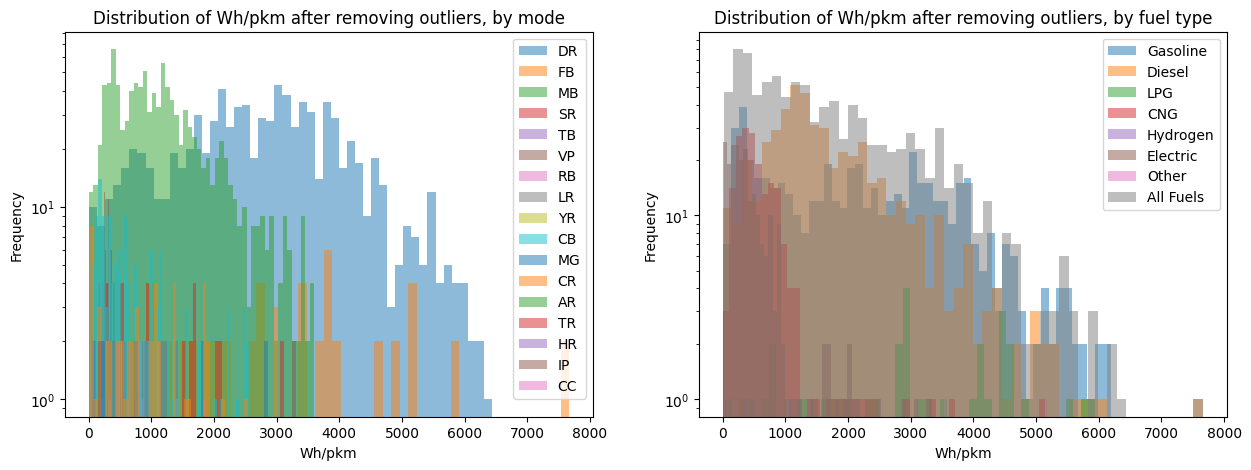

Creating ../src/emcommon/resources/ntd2021_intensities.json


/var/folders/v0/c_n37phn7sq88dx8kvylb8_1c1j_mc/T/ipykernel_1064/857962386.py:18: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


dropping 12 rows with missing UACE Code


/var/folders/v0/c_n37phn7sq88dx8kvylb8_1c1j_mc/T/ipykernel_1064/857962386.py:18: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/var/folders/v0/c_n37phn7sq88dx8kvylb8_1c1j_mc/T/ipykernel_1064/9921474.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  engine_km = df['Train km'].replace(0, pd.NA).fillna(df['Vehicle km'])


Removing outliers
Removing VP outlier: expected (np.float64(3.8790550581647665), np.float64(650.049534067217)), got {'NTD ID': 7, 'Mode': 'VP', 'UACE Code': '28117', 'Gasoline (%)': 100.0, 'Diesel (%)': None, 'LPG (%)': None, 'CNG (%)': None, 'Hydrogen (%)': None, 'Electric (%)': None, 'Other (%)': None, 'All Fuels (%)': 100.0, 'Gasoline (Wh/pkm)': 843.5974925632445, 'Diesel (Wh/pkm)': None, 'LPG (Wh/pkm)': None, 'CNG (Wh/pkm)': None, 'Hydrogen (Wh/pkm)': None, 'Electric (Wh/pkm)': None, 'Other (Wh/pkm)': None, 'All Fuels (Wh/pkm)': 843.5974925632445, 'Unlinked Passenger Trips': 2726}
Removing DR outlier: expected (np.float64(-842.5146270556556), np.float64(7452.071687884365)), got {'NTD ID': 43, 'Mode': 'DR', 'UACE Code': '93862', 'Gasoline (%)': 62.0204272879202, 'Diesel (%)': None, 'LPG (%)': None, 'CNG (%)': None, 'Hydrogen (%)': None, 'Electric (%)': None, 'Other (%)': 37.97957271207979, 'All Fuels (%)': 100.0, 'Gasoline (Wh/pkm)': 7982.240787243367, 'Diesel (Wh/pkm)': None, 'LPG 

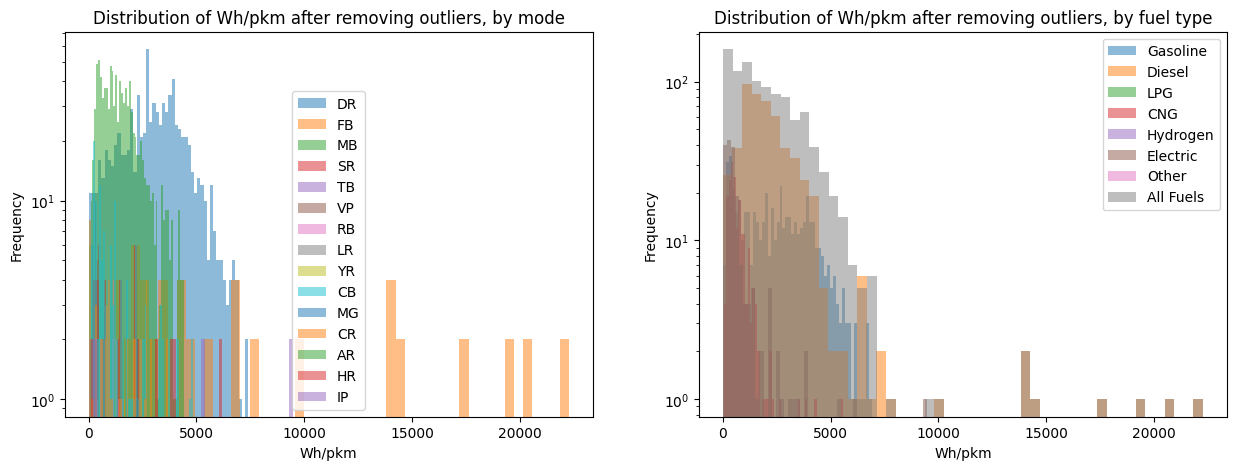

Creating ../src/emcommon/resources/ntd2020_intensities.json


/var/folders/v0/c_n37phn7sq88dx8kvylb8_1c1j_mc/T/ipykernel_1064/857962386.py:18: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


dropping 12 rows with missing UACE Code


/var/folders/v0/c_n37phn7sq88dx8kvylb8_1c1j_mc/T/ipykernel_1064/857962386.py:18: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/var/folders/v0/c_n37phn7sq88dx8kvylb8_1c1j_mc/T/ipykernel_1064/9921474.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  engine_km = df['Train km'].replace(0, pd.NA).fillna(df['Vehicle km'])


Removing outliers
Removing DR outlier: expected (np.float64(-949.0121938605221), np.float64(7428.417143680057)), got {'NTD ID': 5, 'Mode': 'DR', 'UACE Code': '80389', 'Gasoline (%)': 100.0, 'Diesel (%)': None, 'LPG (%)': None, 'CNG (%)': None, 'Hydrogen (%)': None, 'Electric (%)': None, 'Other (%)': None, 'All Fuels (%)': 100.0, 'Gasoline (Wh/pkm)': 17162.35303199348, 'Diesel (Wh/pkm)': None, 'LPG (Wh/pkm)': None, 'CNG (Wh/pkm)': None, 'Hydrogen (Wh/pkm)': None, 'Electric (Wh/pkm)': None, 'Other (Wh/pkm)': None, 'All Fuels (Wh/pkm)': 17798.926684985337, 'Unlinked Passenger Trips': 53400}
Removing DR outlier: expected (np.float64(-949.0121938605221), np.float64(7428.417143680057)), got {'NTD ID': 19, 'Mode': 'DR', 'UACE Code': '65242', 'Gasoline (%)': 1.6841629232701998, 'Diesel (%)': 70.81388537750883, 'LPG (%)': None, 'CNG (%)': None, 'Hydrogen (%)': None, 'Electric (%)': None, 'Other (%)': 27.50195169922097, 'All Fuels (%)': 100.0, 'Gasoline (Wh/pkm)': 21699.10426235358, 'Diesel (Wh/

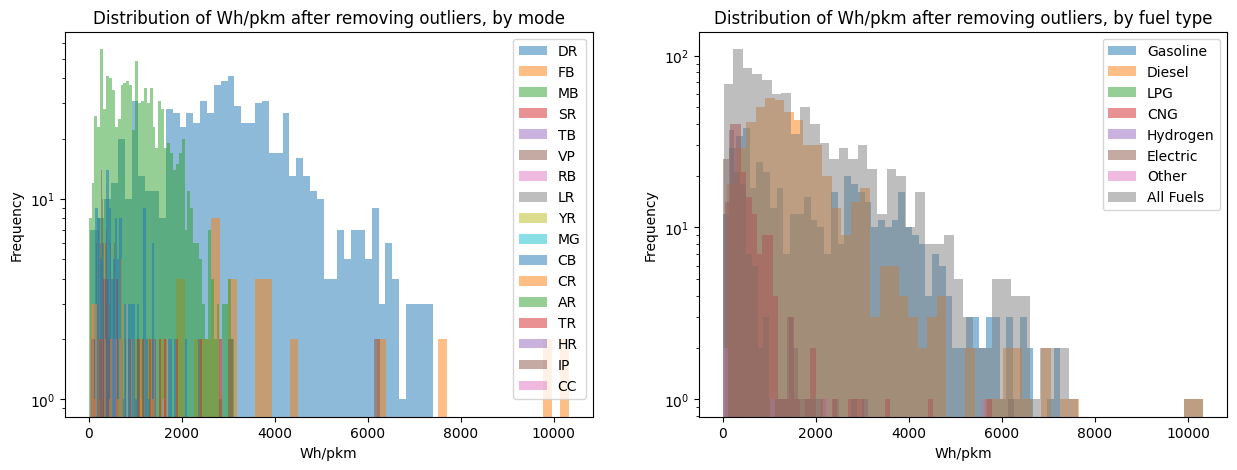

Creating ../src/emcommon/resources/ntd2019_intensities.json


/var/folders/v0/c_n37phn7sq88dx8kvylb8_1c1j_mc/T/ipykernel_1064/857962386.py:18: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


dropping 12 rows with missing UACE Code


/var/folders/v0/c_n37phn7sq88dx8kvylb8_1c1j_mc/T/ipykernel_1064/857962386.py:18: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/var/folders/v0/c_n37phn7sq88dx8kvylb8_1c1j_mc/T/ipykernel_1064/9921474.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  engine_km = df['Train km'].replace(0, pd.NA).fillna(df['Vehicle km'])


Removing outliers
Removing MB outlier: expected (np.float64(-314.9536671049967), np.float64(2122.973731690973)), got {'NTD ID': 11.0, 'Mode': 'MB', 'UACE Code': '08785', 'Gasoline (%)': 0.9856837866126754, 'Diesel (%)': 1.5816709027409535, 'LPG (%)': None, 'CNG (%)': 97.43264531064636, 'Hydrogen (%)': None, 'Electric (%)': None, 'Other (%)': None, 'All Fuels (%)': 100.0, 'Gasoline (Wh/pkm)': 11654.058437820127, 'Diesel (Wh/pkm)': 1393.0978668952143, 'LPG (Wh/pkm)': None, 'CNG (Wh/pkm)': 275.7418369109718, 'Hydrogen (Wh/pkm)': None, 'Electric (Wh/pkm)': None, 'Other (Wh/pkm)': None, 'All Fuels (Wh/pkm)': 405.56895404187406, 'Unlinked Passenger Trips': 1213678}
Removing DR outlier: expected (np.float64(-762.032850335351), np.float64(5999.164740240429)), got {'NTD ID': 10040.0, 'Mode': 'DR', 'UACE Code': '64135', 'Gasoline (%)': 9.929117804887099, 'Diesel (%)': 90.0708821951129, 'LPG (%)': None, 'CNG (%)': None, 'Hydrogen (%)': None, 'Electric (%)': None, 'Other (%)': None, 'All Fuels (%)

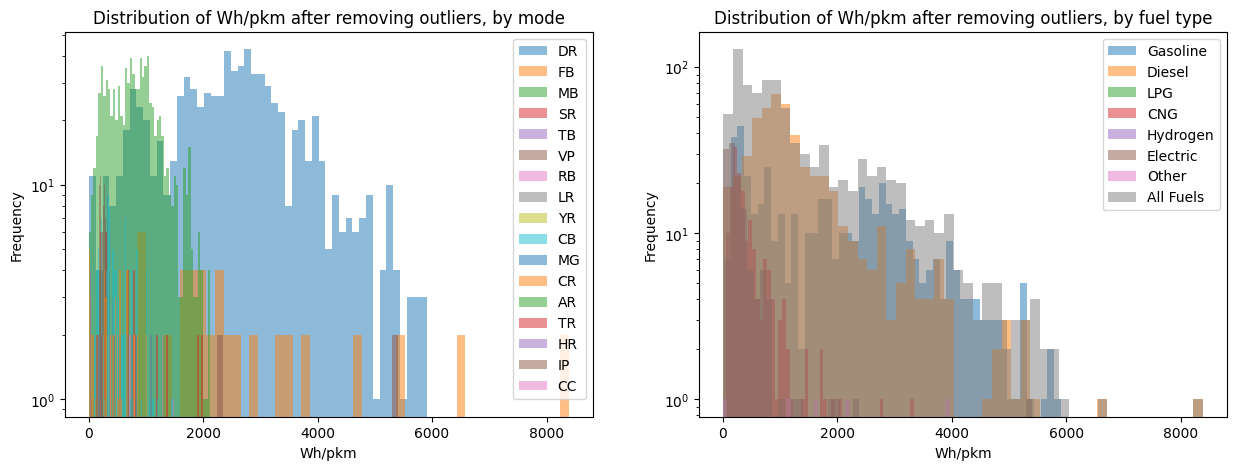

Creating ../src/emcommon/resources/ntd2018_intensities.json


/var/folders/v0/c_n37phn7sq88dx8kvylb8_1c1j_mc/T/ipykernel_1064/857962386.py:18: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


dropping 16 rows with missing UACE Code


/var/folders/v0/c_n37phn7sq88dx8kvylb8_1c1j_mc/T/ipykernel_1064/857962386.py:18: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/var/folders/v0/c_n37phn7sq88dx8kvylb8_1c1j_mc/T/ipykernel_1064/9921474.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  engine_km = df['Train km'].replace(0, pd.NA).fillna(df['Vehicle km'])


Removing outliers
Removing DR outlier: expected (np.float64(-89.99857131886074), np.float64(5720.025496865693)), got {'NTD ID': 6.0, 'Mode': 'DR', 'UACE Code': '97507', 'Gasoline (%)': 100.0, 'Diesel (%)': None, 'LPG (%)': None, 'CNG (%)': None, 'Hydrogen (%)': None, 'Electric (%)': None, 'Other (%)': None, 'All Fuels (%)': 100.0, 'Gasoline (Wh/pkm)': 11209.528940468328, 'Diesel (Wh/pkm)': None, 'LPG (Wh/pkm)': None, 'CNG (Wh/pkm)': None, 'Hydrogen (Wh/pkm)': None, 'Electric (Wh/pkm)': None, 'Other (Wh/pkm)': None, 'All Fuels (Wh/pkm)': 11209.528940468328, 'Unlinked Passenger Trips': 69112}
Removing DR outlier: expected (np.float64(-89.99857131886074), np.float64(5720.025496865693)), got {'NTD ID': 25.0, 'Mode': 'DR', 'UACE Code': '78229', 'Gasoline (%)': 78.1206090549862, 'Diesel (%)': 21.879390945013803, 'LPG (%)': None, 'CNG (%)': None, 'Hydrogen (%)': None, 'Electric (%)': None, 'Other (%)': None, 'All Fuels (%)': 100.0, 'Gasoline (Wh/pkm)': 10678.682094598293, 'Diesel (Wh/pkm)': 5

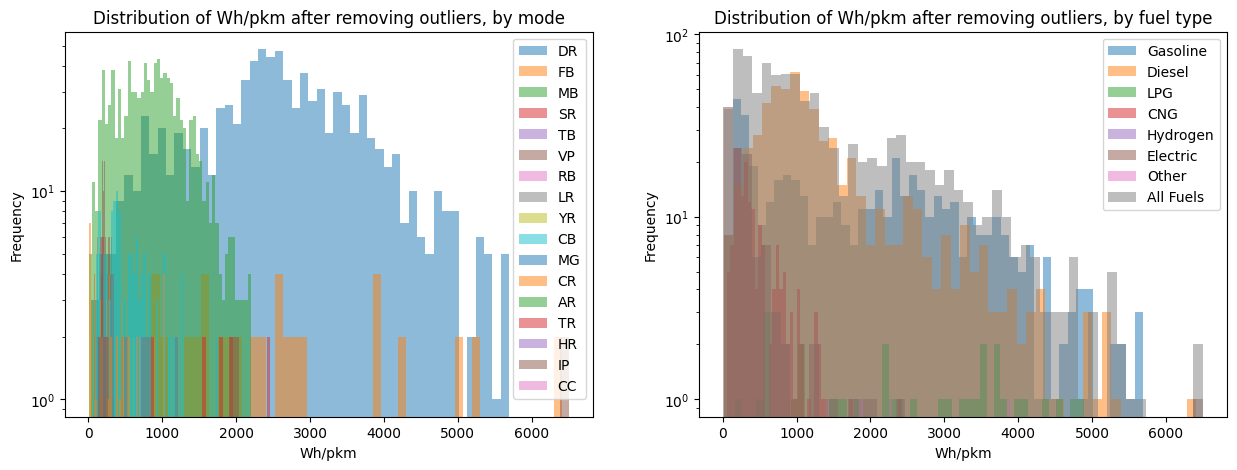

Done generating NTD intensities json files


In [9]:
for year in ntd_urls:
    urls = ntd_urls[year].values()
    output_filename = f"../src/emcommon/resources/ntd{year}_intensities.json"

    if is_up_to_date(output_filename, urls):
      continue

    df = make_merged_ntd_df(year)
    df = remove_outliers(df)

    # convert to JSON
    df = df.convert_dtypes()
    records = df.to_dict(orient='records')
    # remove NA values since they are not JSON serializable and just take up space
    records = [ { k: v for k, v in record.items() if v and v == v } for record in records ]

    output = {
       "records": records,
       "metadata": {
          "year": year,
          "data_source_urls": list(urls)
      }
    }
    with open(output_filename, 'w') as f:
        json.dump(output, f, indent=2)

print("Done generating NTD intensities json files")